In [1]:
import sys
import seaborn
import os.path as path
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
ROOT_PATH = path.abspath(path.join(".."))
sys.path.insert(4, f"{ROOT_PATH}")

from src.utils import *
from src.models.models import *
from src.notebook_utils import *
from src.data.clean_data import *
from src.models.evaluate import *
from src.data.make_dataset import *
from src.data.data_loader import *

%matplotlib inline

pd.options.mode.chained_assignment = None

## Introduction

Mandarin Chinese is a tonal language; each tone said can change the meaning of a word. There are five tones in Mandarin Chinese native speaker can differentiate. The purpose of this project is to train a model to replicate this skill, separating audio files into tone classes.

Advancements in computer vision have led most sound recognition projects to visualise the data into a spectrogram. But a spectrogram alone may not be useful for this project. A Mel spectrogram is a combination of a spectrogram, visualising sound vibrations, and a Mel scale, transforming linear frequencies to represent sounds humans consider important. That means a Mel Spectrogram will be able to visualise sound vibrations and also represent human's limitation in detecting sound frequencies. Using this data our model can learn to differences in the similar to a native Chinese Speaker.

A text file, including the Chinese dictionary, is used to build a list of unique Chinese Characters. I then requested pronunciations of each character from  https://api.forvo.com/.  The variety of words forces the model to learn patterns in the tones,  not the words. 

The audio pronunciations are made by real people, leading to more human error. To ensure the audio data is suitable for training I removed excess silence, computed the PCA to remove outliers and used Speach Recognition to assess the quality of the data. I then sampled data with a representative tone class distribution so it can perform well in the real world. There is tradeoff using this method; although the quality of the data improved, this method removes a huge portion of the original dataset.

To make up for the loss during the data cleaning process, augmenting the data creates enough samples for training. Through manipulating the frequencies, noise injection or shifting the sound builds four the times more of the original dataset. Increasing the size of the dataset lowers the risk of the model overfitting.

To finalise the data I converted the audio files into Mel spectrograms, storing the pixels and the label into a NumPy array. Then I used a PyTorch DataLoader to convert the data into tensors. 

There are three models used in this project:
1. SimpleCNN: 2 convolutional layers
2. ComplexCNN: 5 convolutional layers
3. DeepCNN: 9 convolutional layers

The ComplexCNN performing the best, achieving a 90% accuracy score, and the DeepCNN performing the worst, 85% accuracy scores, tells me more layers improve performance, but at a certain threshold. All models performed well, informing me the quality of the data is good for training.

## Request Data

Building a list of unique Chinese characters.

In [9]:
chinese_words = extract_words()

# Total words: 10320.


Word examples

In [27]:
chinese_words[:10]

['冠', '病', '毒', '状', '三', '合', '症', '体', '综', '胶']

These two functions request the pronunciations and then save them.
* limit: maximum times you can request the same word

Note: I can only make 500 requests per day through this website, so we slice 500 words each day from our word list.

In [6]:
mp3_urls = request_pronunciations(chinese_words, API_KEY, limit=4)
audio_list = save_pronunciations(mp3_urls)

100%|██████████| 455/455 [03:16<00:00,  2.32it/s]


Building a DataFrame and also appending the previous appended dataset.

In [7]:
audio_data = build_dataframe(audio_list)

Apending Previous Data Set!


The data frame includes information about the audio file's tone, word, and Id.

In [8]:
audio_data.head()

duration                     id  labels  nframes  tone word
0  1.880816  audio_12d24f68-26.wav     0.0    82944   1.0    柑
1  2.481633  audio_29976a3f-f9.wav     2.0   109440   3.0    踵
2  2.377143  audio_8024de27-8c.wav     1.0   104832   2.0    炆
3  2.481633  audio_0c3a35ac-36.wav     0.0   109440   1.0    瓯
4  2.168163  audio_573ca8db-be.wav     1.0    95616   2.0    廻

In [11]:
audio_data.to_pickle(f"{DATA_PATH}/processed/audio_df.pkl")

## Data Exploration


In [2]:
audio_data = pd.read_pickle(f"{DATA_PATH}/processed/audio_df.pkl")

There are null values within the tone and label category, highlighting some error occurred extracting the tone.

In [5]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4405 entries, 0 to 4404
Data columns (total 6 columns):
duration    4405 non-null float64
id          4405 non-null object
labels      4366 non-null float64
nframes     4405 non-null int64
tone        4366 non-null float64
word        4405 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 240.9+ KB


###  Tones

* Tone 1: pronounced in a high pitch
* Tone 2: a low to high pitch sound
* Tone 3: pronounced in a deep pitch
* Tone 4: a high to low pitch sound

Here are few examples of each tone.


In [20]:
play_tones(audio_data)

This confirms the dataset's tone distribution is representative of the real world.

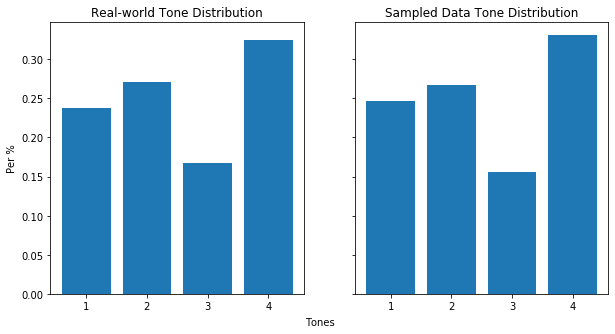

In [22]:
display_tone_distributions(chinese_words, audio_data)

There are few annomlies dected in the audio duration. 

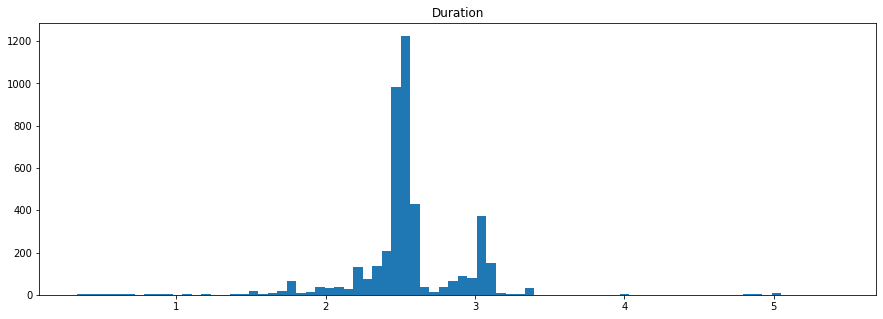

In [8]:
display_duration(audio_data)

The wave plots show that a huge portion of the audio files contain silence.

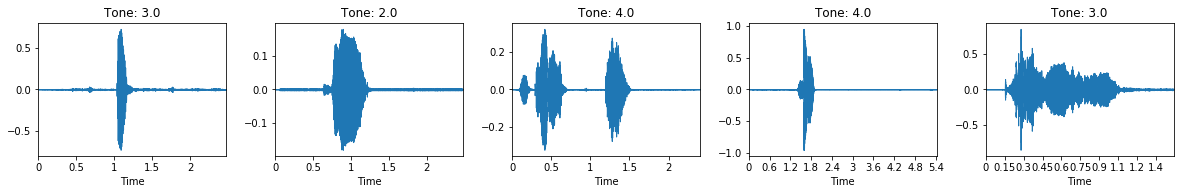

In [9]:
display_waveplots(audio_data)

The Mel spectrograms provide more information about the audio files but are not easy to interpret.

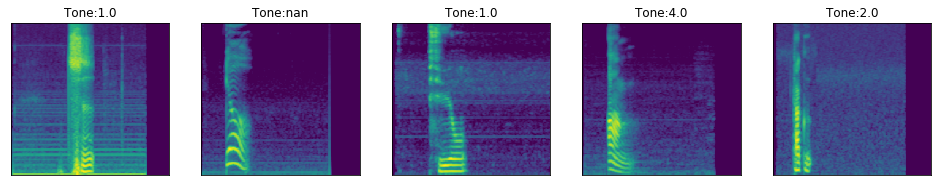

In [11]:
display_specgrams(audio_data)

## Remove Silence

The wave plots showed huge portions of the audio files contain silence. Removing the silence ensures most audio files have similar lengths to simplify the task for the model.  Removing silence can also identify some audio files that include too much Gaussian noise.

Remove all null values in the data.

In [6]:
audio_data = audio_data.dropna()

A function that removes the silence from the audio files.

In [7]:
audio_data = remove_silence(audio_data)

100%|██████████| 4366/4366 [01:31<00:00, 47.79it/s]


A comparison of the audio file with and without the silence.

In [8]:
play_audio_length(audio_data)

Word: 暄, Tone: 1.0


The range of the audio file length has decreased after removing the silence. Outliers are still visible, audio files longer than 2 seconds.

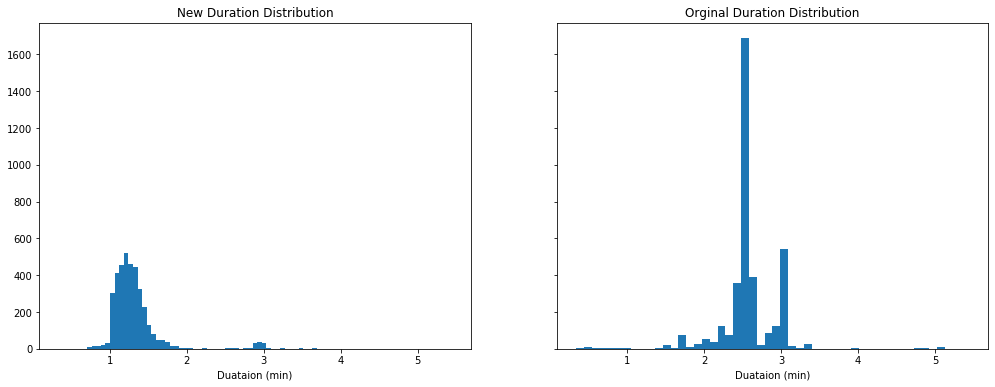

In [9]:
display_duration_comparison(audio_data)

Audio files longer than 2 seconds tend to include more Gaussian noise, leading to explain why silenced was not removed.   While using this silence removing metho,  I can identify the lower quality audio files. 

Here are two examples of the longer audio files.

In [10]:
play_long_audio(audio_data)

Removing audio files longer than 2 seconds.

In [11]:
audio_data = audio_data[audio_data['new_duration'] < 2]

## Data Augmentation

The data cleaning process removes nearly half of the audio files. The remaining data will not be enough to prevent the model from overfitting.  

Using data augmentation can artificially produce more data samples for this project.  By manipulating the frequencies, noise injection or shifting the sound, I can produce four variations of the same audio file

Here are examples of different audio types.

In [12]:
play_aug(audio_data)

There are noticeable differences within each wave plot of the same file.

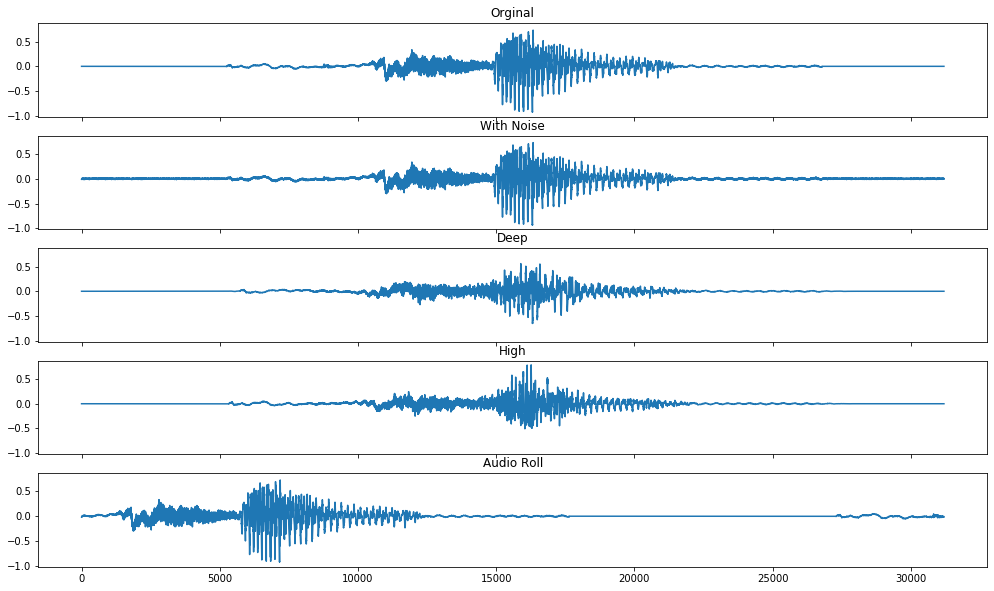

In [13]:
display_aug(audio_data)

Now there are enough samples to prevent overfitting occurring.

In [14]:
audio_data_ag = audio_augmentation(audio_data)                   

100%|██████████| 3609/3609 [16:31<00:00,  3.64it/s]

# Samples Added: 14436 


## PCA

Principle Component Analysis allows me to reduce the dimensions of the Mel Spectrograms, plot the residuals, and then identify any outliers or clusters within the data. Then an Isolation Forest is applied to determine whether or not an observation is an outlier.

A function that computes the PCA and the Isolation Forest.

In [15]:
audio_pca = pca_anomaly_detection(audio_data_ag)
audio_pca.to_pickle(f"{DATA_PATH}/processed/audio_pca.pkl")

100%|██████████| 18045/18045 [14:30<00:00, 20.73it/s] 


There are visiable clusters in relation to the audio data type, confirming important information was retained during dimensionality reduction. However there is not enough information to seperate the tones.

There are no visible tone clusters. Not enough data was retained during the PCA to represent the differences in tones.

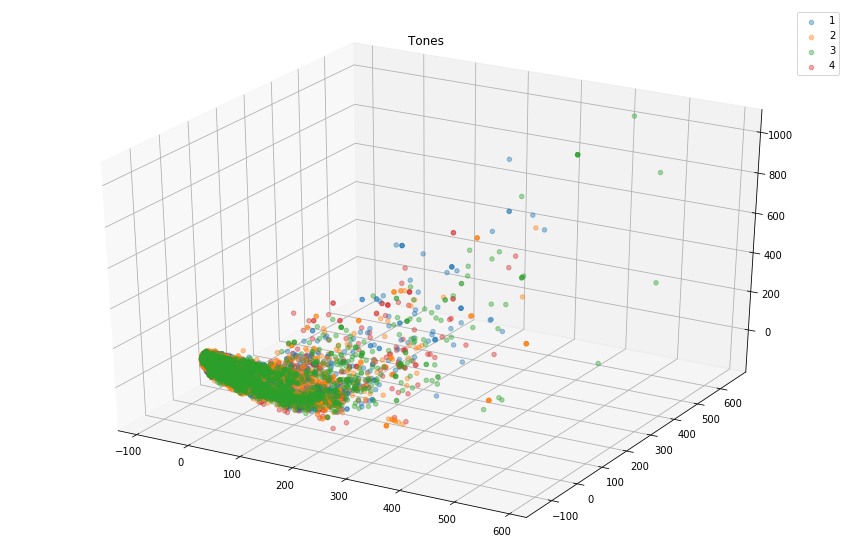

In [17]:
display_pca_tones(audio_pca)

There are visible audio type clusters. The audio data with noise or shifted sound residuals have a larger range than the other audio types.

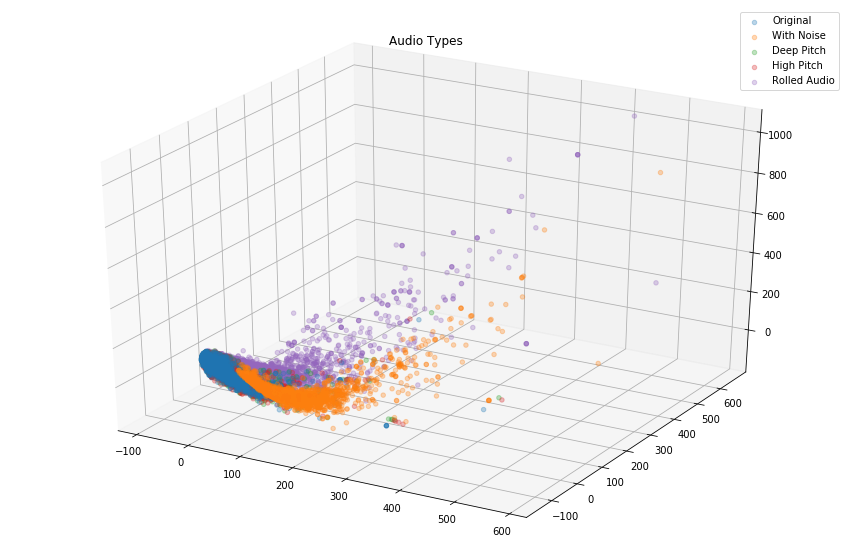

In [18]:
display_pca_types(audio_pca)

Audio data with noise or shifted audio are more likely to class as an outlier.

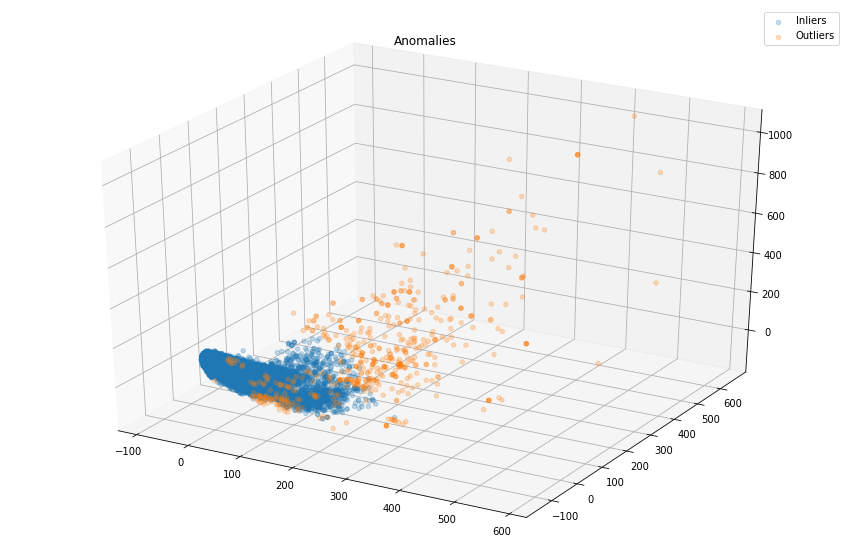

In [19]:
display_outliers(audio_pca)

Error is more common in the audio files labelled as outliers, but this is not always the case. There is not enough information retained during the PCA to make this strong assumption. 

In [24]:
play_anomalies(audio_pca)

Tone: 2.0	Anomaly: 1	Audio Type: RL


Tone: 1.0	Anomaly: -1	Audio Type: RL


I removed the outliers as they could affect model performance.

In [4]:
audio_inlier = audio_pca[audio_pca.anomaly == 1]

## Speech Recognition

Google Speech Recognition is used to assess the quality of the data, remove any inconsistent data and remove audio files that are related to their label.

To label the quality of the data,  I made assumptions based on the results of the transcription task:
* 0: if one of the transcripts match the word
* 1: if one of the transcript's tone matches the tone
* 2: if none of the transcripts matches the word or the tone


In [5]:
audio_cln = speech_recognition_assessment(audio_inlier)

100%|██████████| 17503/17503 [2:40:19<00:00,  1.82it/s]  


The low-quality audio files are more likely not to match its label or lack clarity. Using this data will confuse our model as it won't be able to separate patterns in each class.

In [6]:
play_audio_quality(audio_cln)

Tone: 4.0	Sound Quality: 0.0	Audio Type: RL


Tone: 2.0	Sound Quality: 2.0	Audio Type: DP


I only select data that have sound quality 0 or 1, removing more than half of the augmented dataset. 

In [7]:
data_count = len(audio_inlier)
audio_best = audio_cln[audio_cln.sound_quality <= 1]
print(f'# Samples Removed: {data_count - len(audio_best)}')

# Samples Removed: 8268


## Sampling Data

Within this process, I plan on sampling data that will have a representative of the real-world tone distribution to remove bias.

The distribution of the tones in the dataset does not match the real world, indicating there is added bias. 

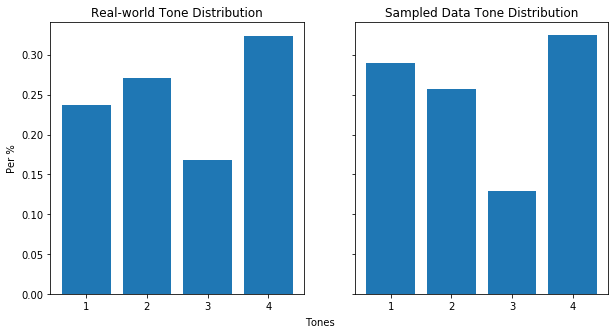

In [17]:
display_tone_distributions(chinese_words, audio_best)

A function that retrieves the real-world tone distribution as a pandas Series.

In [18]:
tone_per = get_tone_distrubtion(chinese_words)

This function samples the data to match the real-world tone distribution.

In [19]:
audio_pr = sample_tone_per(audio_best, tone_per)

# Samples Removed: 2119 


Our sampled data tone distribution is now representative.

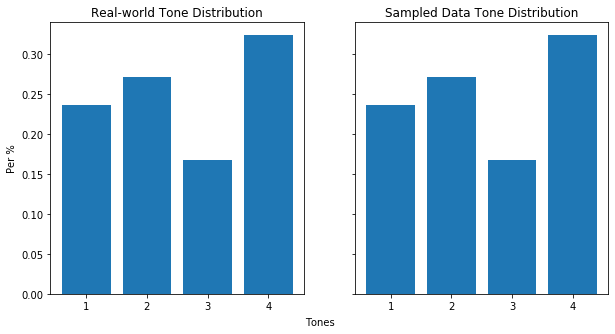

In [21]:
display_tone_distributions(chinese_words, audio_pr)

In [23]:
print(len(audio_pr))

7116


In [24]:
audio_pr.to_pickle(f'{ROOT_DIR}/data/processed/audio_pr.pkl')

## Data Preperation

In [25]:
audio_pr = pd.read_pickle(f'{ROOT_DIR}/data/processed/audio_pr.pkl')

Splitting the data

In [167]:
train, valid, test = split_data(audio_pr, test_per=0.05, val_per=0.15)

# Train Size: 3968
# Valid Size: 743
# Test Size: 247


Here I convert the audio files into Mel spectrograms and then load them into PyTorch tensor. 

The duration indicates the length I will transform each audio file using padding, ensuring each spectrogram has the same dimensions. 

In [133]:
train_loader, valid_loader, test_loader = prepare_data(train, valid, test, duration=2)

100%|██████████| 76/76 [00:08<00:00,  8.66it/s]


## Train

There are three models of different complexities in this project. Comparing the results gives me a strong basis on ways to tune the model for optimum performance.

### Base Model

The simple CNN, used as the base model, is composed of two convolutional layers.

In [3]:
simpleCNN = SimpleCNN()
print(simpleCNN)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=74240, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (log_softmax): LogSoftmax()
)


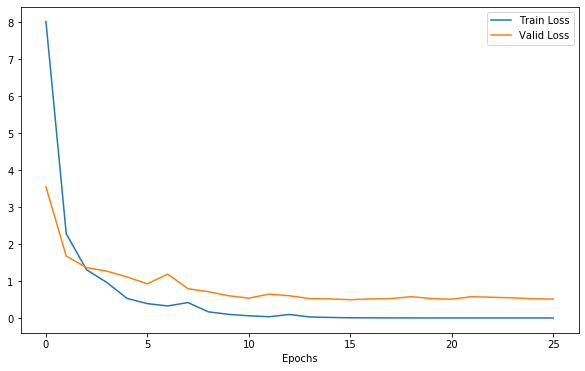

In [4]:
display_model_loss(simpleCNN)

### ComplexCNN

The complexCNN has five convolutional layers, uses batch normalisation to stabilise neurons and a drop out layer to reduce overfitting. 

In [5]:
complexCNN = ComplexCNN()
print(complexCNN)

ComplexCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=131328, out_features=512, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (log_softmax): LogSoftmax()
)


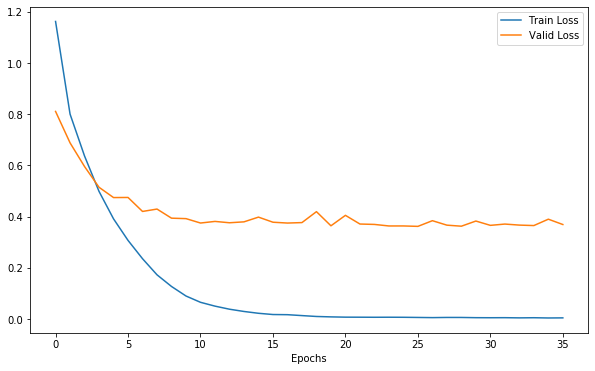

In [6]:
display_model_loss(complexCNN)

## DeepCNN


The is composed of nine convolutional layers, batch normalisation, and dropout.

In [7]:
deepCNN = DeepCNN()

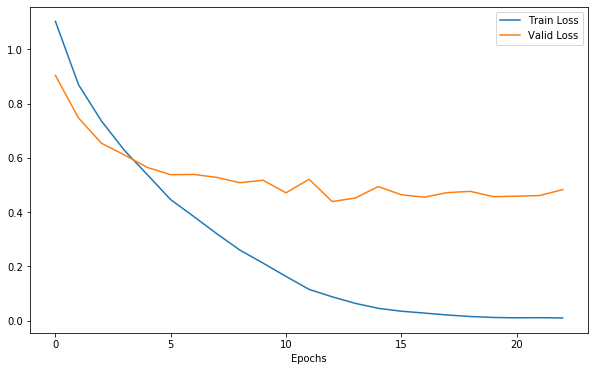

In [8]:
display_model_loss(deepCNN)

It is clear the ComplexCNN outperfromed all three models

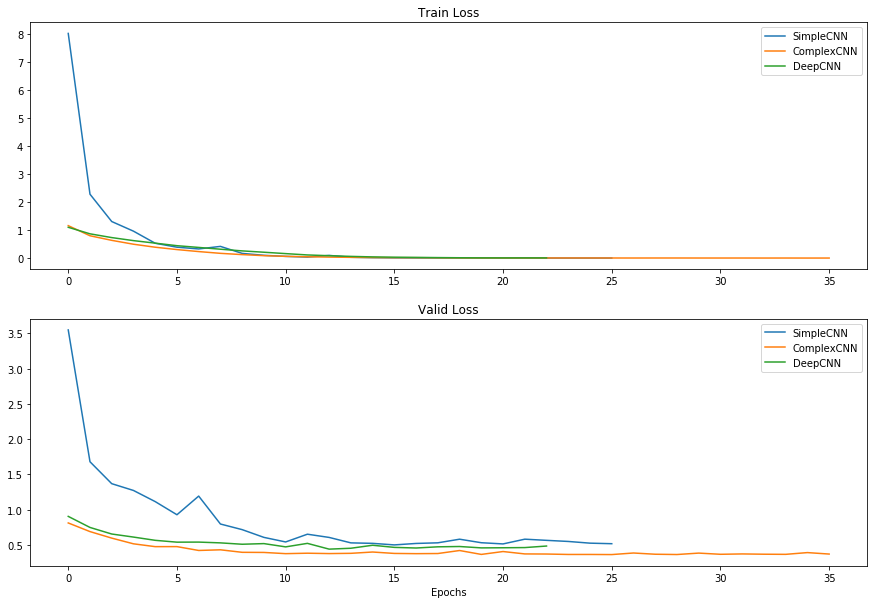

In [9]:
compare_model_loss(simpleCNN, complexCNN, deepCNN)

## Test Model

 The ComplexCNN perfomred the best on the test set

In [11]:
test_loader = load_object(f'{DATA_PATH}/interim/test_loader.pkl')

In [12]:
test_model(simpleCNN, test_loader)

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


{'SimpleCNN': 0.8793103448275862}

In [13]:
test_model(complexCNN, test_loader)

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


{'ComplexCNN': 0.9}

In [15]:
test_model(deepCNN, test_loader)

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


{'DeepCNN': 0.8551724137931035}

The ResNet outperformed the other two models

## Conclusion

Each process taken in the data wrangling process is what leads to the high-performing models.  Data augmentation reduces the risk of overfitting. Removing outliers and speech recognition assessment improves the quality of the data. Sampling a representative tone class distribution allows the model to perform better in the real world.

The complexCNN performed the best out the other two models, indicating there is an ideal level of complexity the model should be; increasing the layers will not automatically lead to improved performance. However, all models performed well, achieving above a 85% accuracy score. 
